## Times Series Forecasting- Forecasting Champagne sales
### The notebook gives an Idea of how to use apply statisctical methods like ARIMA, SARIMA on a time-series Data
### Explains concepts like Seasonality, Trend, Residuals, Stationarity along the way 
### Compares ARIMA, SAMRIMA to the state-of-the-Art Algorithm for dependent data the LSTM's.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error
import warnings
#warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [4]:
# Import the Dataset

In [227]:
df = pd.read_excel('perrin-freres-monthly-champagne-.xlsx', skiprows=12)

In [228]:
df.drop(columns='Unnamed: 2', inplace=True)

In [229]:
df.columns = ['Month', 'Sales']

In [230]:
# Converting the Dataframe into time series

In [64]:
df.index = pd.to_datetime(df['Month'], format='%y-%m')
df.tail()

,Month,Sales
Month,,
1972-05-01,1972-05-01,4618
1972-06-01,1972-06-01,5312
1972-07-01,1972-07-01,4298
1972-08-01,1972-08-01,1413
1972-09-01,1972-09-01,5877


In [51]:
df.isnull().sum()

Month    0
Sales    0
dtype: int64

In [52]:
df.describe()

,Sales
count,105.000000
mean,4761.152381
std,2553.502601
min,1413.000000
25%,3113.000000
50%,4217.000000
75%,5221.000000
max,13916.000000


In [ ]:
#Splitting the Dataset into ts_train and ts_test set

In [196]:
ts_train = df[df.index.year != 1972]['Sales']
ts_test = df[df.index.year == 1972]['Sales']
print('ts_train example: ', ts_train.shape[0])
print('ts_test example: ', ts_test.shape[0])

ts_train example:  96
ts_test example:  9


In [197]:
ts_train.head()

Month
1964-01-01    2815
1964-02-01    2672
1964-03-01    2755
1964-04-01    2721
1964-05-01    2946
Name: Sales, dtype: int64

In [184]:
# Time Series plot and Stationarity
# Plots for intial Analysis

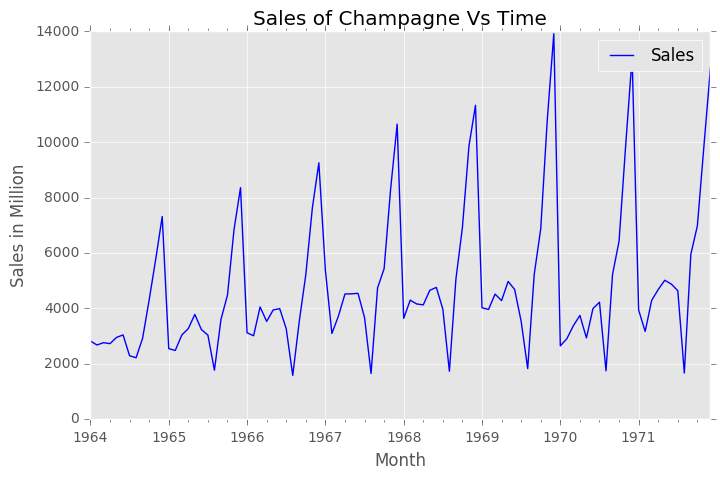

In [185]:
ts_train.plot(figsize=(8,5), color = 'blue')
plt.legend()
plt.ylabel('Sales in Million')
plt.title('Sales of Champagne Vs Time')
plt.show()

In [186]:
# We clearly see a seasonality in the data, we also see the upward trend in the sales 

In [187]:
##Decomposing the plot into Trend, Seasonality, Residuals

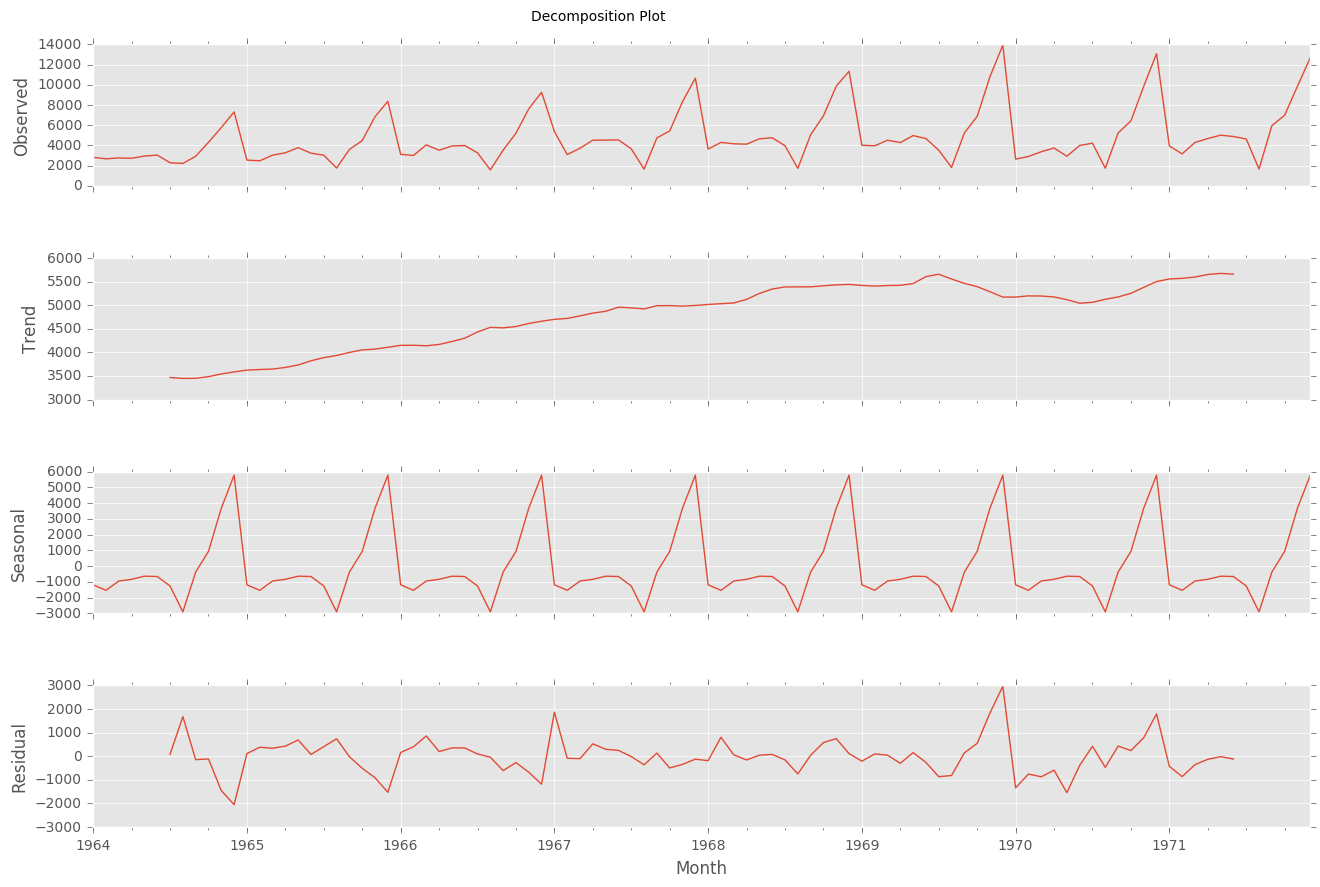

In [188]:
import statsmodels.api as sm

decomposition = sm.tsa.seasonal_decompose(ts_train, model = 'additive', freq =12)
fig = decomposition.plot()
fig.set_size_inches(15,10)
fig.suptitle('Decomposition Plot')
plt.show()

We can clearly see the seasonality in the data. There looks like there is some trend as well. The residual is also not at all constant. We want to make the series stationary. We can check the stationarity by using the rolling mean as well as using the Dicky Fuller hypothesis ts_test.

The Dicky Fuller ts_test assumes in the null hypothesis that the series is non-stationary. If the ts_test statistic is less than the critical value then the null is rejected and the series is staitonary, else the series is non statonary and we need to use transformations to make the series stationary.


In [189]:
def plot(series,window, title = ''):
    rollmean = series.rolling(window=12).mean()
    rollstd = series.rolling(window=12).std()
    plt.figure(figsize=(8,5))
    series.plot()
    rollmean.plot(label = 'Rolling Mean')
    rollstd.plot(label=" Rolling STD")
    plt.ylabel('Sales in Millions')
    #plt.figure(figsize=(12,8))
    plt.title(title)
    plt.legend()
    plt.show()

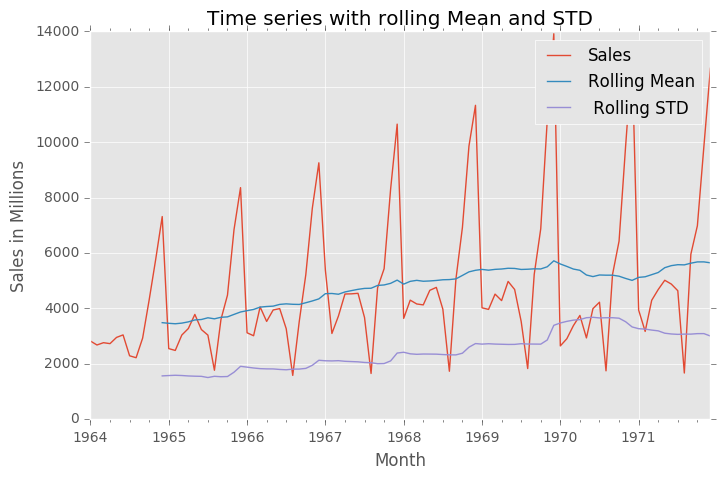

In [190]:
plot(ts_train, 12, 'Time series with rolling Mean and STD')

The plot shows that the rolling mean as well as the standard deviation is not constant, this gives us a hint of non-stationarity. Let us confirm it by using the Dicky Fuller ts_test.

In [191]:
from statsmodels.tsa.stattools import adfuller
def fuller(series):
    dfts_test = adfuller(series, autolag = 'AIC')
    values_names = ['ts_test Statistic', 'p-value', 'No of lags', 'No of Observation']
    for value_name, value in list(zip(values_names,dfts_test)):
        print(value_name, ':', value)
    print('critical values: ', dfts_test[4])

In [192]:
fuller(ts_train)

Test Statistic : -1.620556775833514
p-value : 0.4724374136239982
No of lags : 11
No of Observation : 84
critical values:  {'5%': -2.8966159448223734, '10%': -2.5854823866213152, '1%': -3.510711795769895}


The ts_test shows that the ts_test statistic is greater than the 1% value. This shows that we cannot reject the null hypothesis and the series is non-stationary.

Now we will make the series stationary. Since the series has seasonality which is quite clearly visible, we can remove the seasonality by shifting the series by 12 and subtracting it from the orignal series.


In [114]:
seasonal_diff = ts_train -ts_train.shift(12)
seasonal_diff.dropna(inplace = True)

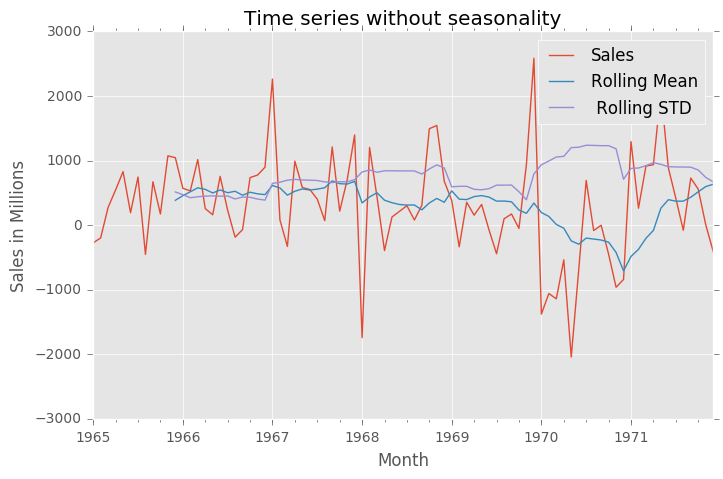

In [119]:
plot(seasonal_diff, 12, 'Time series without seasonality')

Now that we have removed the stationarity from our time series, we can make the ACF(Auto-correlation function) and PACF(Partial Auto-correlation function) plots which will help us decide the parameters of our Arima model.

In [122]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [123]:
acf = acf(seasonal_diff, nlags=40)
pacf = pacf(seasonal_diff, nlags=40)

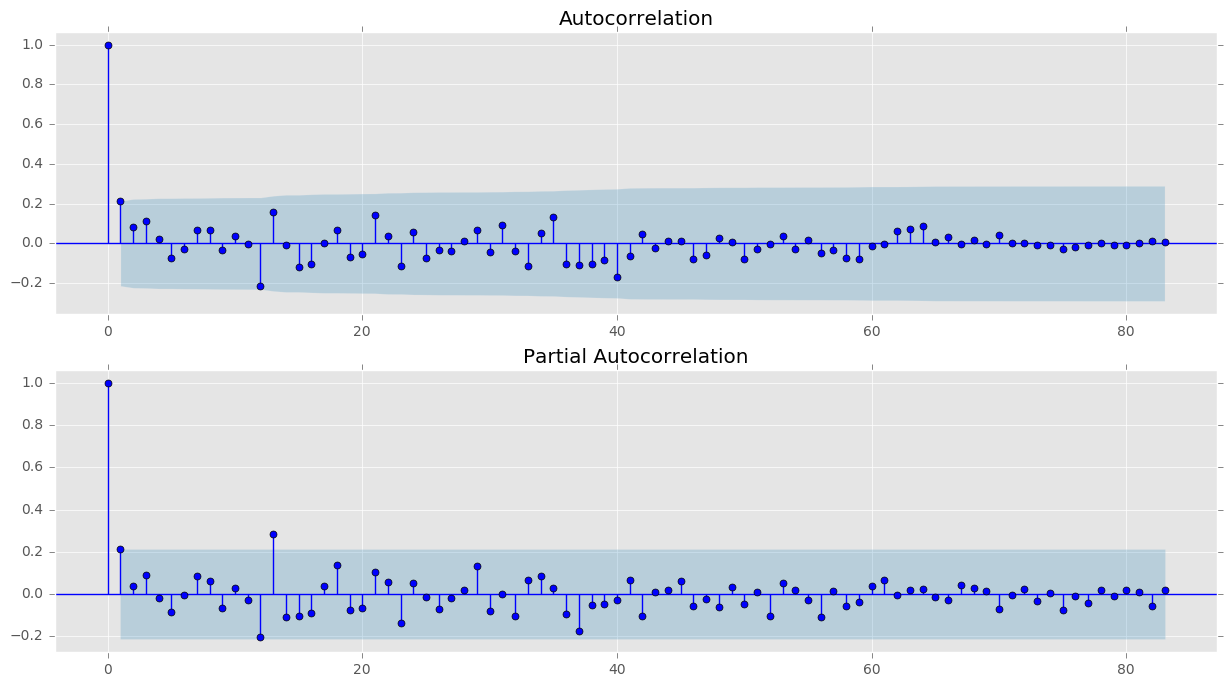

In [132]:
plt.figure(figsize=(15,8))
plt.subplot(211)
plot_acf(seasonal_diff, ax = plt.gca(), color = 'blue')
plt.subplot(212)
plot_pacf(seasonal_diff, ax = plt.gca(), color = 'blue')
plt.show()


As you can see, that there are only a few significant values in both the ACF and the PACF. Both the PACF and ACF drop off suddenly, perhaps suggesting a mix of AR and MA models. All this is insignificant for us as we will try a bunch of different parameters and choose the one with lower RMSE(root mean square error).

We define a function to take the seasonal difference for a series to remove the seasonality.

As the model will predict values for non-seasonal data we need to add back the seasonal components we subtracted to get the true predictions. We define a function called inverse_seas_diff to inverse the seasonal difference of the series.

In [162]:
def inverse_seas_diff(original, value, interval):
    return value + original.iloc[-interval]

def make_seas_diff(original, interval):
    seasonal_diff_ts = original - original.shift(interval)
    seasonal_diff_ts.dropna(inplace  =True)
    return list(seasonal_diff_ts)


In [163]:
# Modelling

In [164]:
from statsmodels.tsa.arima_model import ARIMA

The method we will use is feed forward validation. How this works is that we will build a model by iterating over every value in the ts_test set. For every value in the ts_test set-

We will take the ts_train set and remove its seasonality.
Build a model using the non-stationary data.
Forecast the next value using the model.
Add the true value to the ts_train set.
Add the predicted value to the predictions list.
Go to step 1.
At the end we will find the rmse, using the predictions and the ts_test set.

In [171]:
def rmse(order):
    
    ts_train_list = list(ts_train)
    predictions = []
    for index,true_value in ts_test.iteritems(): 
        seasonal_diff_ts = make_seas_diff(pd.Series(ts_train_list),12)
        model = ARIMA(seasonal_diff_ts, order=order)
        results_AR = model.fit(trend = 'nc',disp=0)
        pred = results_AR.forecast()[0][0]
        pred = inverse_seas_diff(pd.Series(ts_train_list),pred,12)
        ts_train_list.append(true_value)
        predictions.append(pred)

    return ('RMSE: ', mean_squared_error(list(ts_test), predictions) ** 0.5)

We will try all possible combinations of parameters for (p,d,q) and then compute rmses for each combination. For some of the combinations the underlying code in the library will give errors due to mathematical operations. We will skip those.

In [174]:
import itertools
p = range(0,5)
d = range(0,3)
q = range(0,5)
combinations = list(itertools.product(p,d,q))

for parameter in combinations:
    try:
        order = parameter
        print(order,':', rmse(order))
    except:
        continue

C:\Users\Shrinivas Kallol\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\Shrinivas Kallol\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
C:\Users\Shrinivas Kallol\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


(0, 1, 1) : ('RMSE: ', 350.79730501845415)
(0, 1, 2) : ('RMSE: ', 360.3713632150959)
(0, 2, 1) : ('RMSE: ', 504.4348919427254)
(1, 1, 0) : ('RMSE: ', 421.25622054578247)
(1, 1, 1) : ('RMSE: ', 363.48117164198493)


C:\Users\Shrinivas Kallol\Anaconda3\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(1, 1, 2) : ('RMSE: ', 366.18855568509207)
(1, 1, 3) : ('RMSE: ', 364.9834982257005)
(1, 2, 0) : ('RMSE: ', 711.95257713361)
(2, 1, 0) : ('RMSE: ', 370.77751874670474)
(2, 1, 1) : ('RMSE: ', 372.18117795302646)


C:\Users\Shrinivas Kallol\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:654: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\Shrinivas Kallol\Anaconda3\lib\site-packages\statsmodels\tools\numdiff.py:96: RuntimeWarning: invalid value encountered in maximum
  h = EPS**(1. / s) * np.maximum(np.abs(x), 0.1)
C:\Users\Shrinivas Kallol\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:628: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\Shrinivas Kallol\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:629: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\Shrinivas Kallol\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:654: RuntimeWarning: invalid value encountered in true_divide
  R_mat, T_mat)


(2, 1, 3) : ('RMSE: ', 331.68776440923955)
(2, 2, 0) : ('RMSE: ', 614.0126798217409)
(2, 2, 1) : ('RMSE: ', 372.0606455591632)


C:\Users\Shrinivas Kallol\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Shrinivas Kallol\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:584: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
C:\Users\Shrinivas Kallol\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:585: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
C:\Users\Shrinivas Kallol\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:585: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
C:\Users\Shrinivas Kallol\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:586: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
C:\Users\Shrinivas Kallol\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:587: RuntimeWarning: overflow encount

(3, 1, 0) : ('RMSE: ', 348.13949296394094)
(3, 1, 1) : ('RMSE: ', 364.9654494055192)


C:\Users\Shrinivas Kallol\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(3, 1, 2) : ('RMSE: ', 365.48030189982967)
(3, 2, 0) : ('RMSE: ', 534.5557824019274)
(3, 2, 1) : ('RMSE: ', 350.25708356077234)


C:\Users\Shrinivas Kallol\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:652: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
C:\Users\Shrinivas Kallol\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:654: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
C:\Users\Shrinivas Kallol\Anaconda3\lib\site-packages\statsmodels\tools\numdiff.py:243: RuntimeWarning: invalid value encountered in add
  **kwargs)).imag/2./hess[i, j]
C:\Users\Shrinivas Kallol\Anaconda3\lib\site-packages\statsmodels\tools\numdiff.py:243: RuntimeWarning: invalid value encountered in multiply
  **kwargs)).imag/2./hess[i, j]
C:\Users\Shrinivas Kallol\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Shrinivas Kallol\Anaconda3\

(4, 1, 0) : ('RMSE: ', 337.36327106744943)
(4, 1, 1) : ('RMSE: ', 366.21756950541226)
(4, 1, 2) : ('RMSE: ', 344.01612090820885)


C:\Users\Shrinivas Kallol\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Shrinivas Kallol\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Shrinivas Kallol\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Shrinivas Kallol\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Shrinivas Kallol\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood opti

(4, 1, 3) : ('RMSE: ', 506.02489858148135)
(4, 2, 0) : ('RMSE: ', 451.7164490009705)
(4, 2, 1) : ('RMSE: ', 340.71435296444537)


RMSE:  350.79730501845415


C:\Users\Shrinivas Kallol\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\Shrinivas Kallol\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
C:\Users\Shrinivas Kallol\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


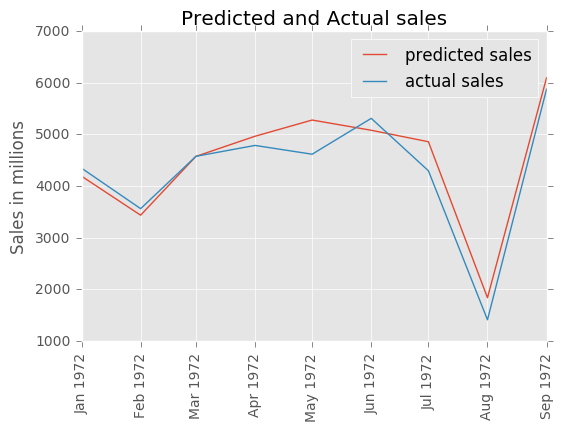

In [201]:
ts_train_list = list(ts_train)
predictions = []
for index,true_value in ts_test.iteritems(): 
    seasonal_diff_ts = make_seas_diff(pd.Series(ts_train_list),12)
    model = ARIMA(seasonal_diff_ts, order= (0,1,1))
    results_AR = model.fit(trend = 'nc',disp=0)
    pred = results_AR.forecast()[0][0]
    pred = inverse_seas_diff(pd.Series(ts_train_list),pred,12)
    ts_train_list.append(true_value)
    predictions.append(pred)

print ('RMSE: ', mean_squared_error(list(ts_test), predictions) ** 0.5)

pred_series =  pd.Series(predictions, index = ts_test.index)
plt.plot(pred_series, label = 'predicted sales')
plt.plot(ts_test, label = 'actual sales')
plt.xticks(rotation = 'vertical')
plt.ylabel('Sales in millions')
plt.title('Predicted and Actual sales')
plt.legend()

By plotting the actual and predicted values for the last 9 months in the test set we can see that the predicted sales match the actual sales in the last 9 months quite well.

Let us go a step ahead and build a Seasonal-ARIMA or SARIMA model. In this model we specify additional parameters (P,D,Q,m) for modelling the seasonality along with the general parameters (p,d,q). 'm' stands for the number of periods for which the seasonality exists.

As we are building a seasonal-ARIMA model we don't need to remove the seasonality. Let us choose P=0, D=1, Q=1 and m is 12.

In [202]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


RMSE:  328.8806659384535


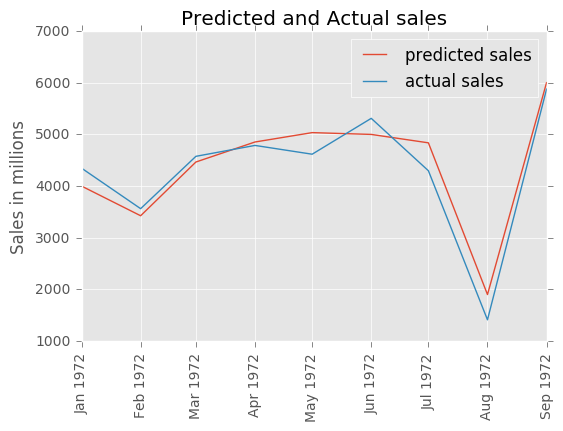

In [203]:
train_list = list(ts_train)
predictions = []
for index,true_value in ts_test.iteritems(): 
    model = SARIMAX(train_list, trend='n', order=(0,1,1), seasonal_order=(0,1,1,12))
    results_AR = model.fit(trend = 'nc',disp=0)
    pred = results_AR.forecast()[0]
    train_list.append(true_value)
    predictions.append(pred)

print ('RMSE: ', mean_squared_error(list(ts_test), predictions) ** 0.5)

pred_series =  pd.Series(predictions, index = ts_test.index)
plt.plot(pred_series, label = 'predicted sales')
plt.plot(ts_test, label = 'actual sales')
plt.xticks(rotation = 'vertical')
plt.ylabel('Sales in millions')
plt.title('Predicted and Actual sales')
plt.legend()

As we can see that the RMSE is lower than the ARIMA model and the plot also shows that the predicted and actual sales match upto quite an extent.

## LSTM'S for Time Series Prediction

In [284]:
import numpy as np
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [207]:
np.random.seed(99)

In [213]:
df.drop(columns='Month', inplace=True)

In [215]:
df.reset_index(inplace=True)

In [217]:
df = df.values

In [475]:
data = df[['Sales']]

In [476]:
data = data.astype('float32')

In [477]:
#Normalizing Values

In [478]:
scaler = MinMaxScaler(feature_range=(0,1))

In [479]:
data = scaler.fit_transform(data)

In [480]:
#split into train and test data
train_size = int(len(data)*0.67)
test_size = len(data) - train_size
train, test = data[0:train_size,:], data[train_size : len(data),:]
print(len(train),len(test))

70 35


In [481]:
#Convert an array of values into a dataset matrix
def create_dataset(data, look_back = 1):
    dataX, dataY = [],[]
    for i in range(len(data) - look_back-1):
        a = data[i:(i+look_back),0]
        dataX.append(a)
        dataY.append(data[i+look_back,0])
    return np.array(dataX), np.array(dataY)

In [482]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

### LSTM accepts input in the form [Samples, time steps, features]

In [483]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX,(testX.shape[0],1, testX.shape[1]))

In [484]:
#### Building the Model

In [486]:
model = Sequential()
model.add(LSTM(6,input_shape = (1,look_back)))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer ='adam')
model.fit(trainX, trainY, epochs = 1000, batch_size = 1, verbose =2)

Epoch 1/1000
 - 3s - loss: 0.0687
Epoch 2/1000
 - 0s - loss: 0.0379
Epoch 3/1000
 - 0s - loss: 0.0281
Epoch 4/1000
 - 0s - loss: 0.0257
Epoch 5/1000
 - 0s - loss: 0.0251
Epoch 6/1000
 - 0s - loss: 0.0249
Epoch 7/1000
 - 0s - loss: 0.0245
Epoch 8/1000
 - 0s - loss: 0.0241
Epoch 9/1000
 - 0s - loss: 0.0238
Epoch 10/1000
 - 0s - loss: 0.0237
Epoch 11/1000
 - 0s - loss: 0.0233
Epoch 12/1000
 - 0s - loss: 0.0234
Epoch 13/1000
 - 0s - loss: 0.0229
Epoch 14/1000
 - 0s - loss: 0.0228
Epoch 15/1000
 - 0s - loss: 0.0225
Epoch 16/1000
 - 0s - loss: 0.0226
Epoch 17/1000
 - 0s - loss: 0.0223
Epoch 18/1000
 - 0s - loss: 0.0221
Epoch 19/1000
 - 0s - loss: 0.0220
Epoch 20/1000
 - 0s - loss: 0.0220
Epoch 21/1000
 - 0s - loss: 0.0219
Epoch 22/1000
 - 0s - loss: 0.0218
Epoch 23/1000
 - 0s - loss: 0.0218
Epoch 24/1000
 - 0s - loss: 0.0217
Epoch 25/1000
 - 0s - loss: 0.0218
Epoch 26/1000
 - 0s - loss: 0.0217
Epoch 27/1000
 - 0s - loss: 0.0219
Epoch 28/1000
 - 0s - loss: 0.0219
Epoch 29/1000
 - 0s - loss: 0

we invert the predictions before calculating error scores to ensure that performance is reported in the same units as the original data

In [487]:
trainPredict = model.predict(trainX)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform((trainY).reshape(-1,1))
trainScore = math.sqrt(mean_squared_error(trainY[:,0],trainPredict[:,0]))
print('Train Score %.2f RMSE' %trainScore)
testPredict = model.predict(testX)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform((testY).reshape(-1,1))
testScore = math.sqrt(mean_squared_error(testY[:,0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score 1739.38 RMSE
Test Score: 2660.77 RMSE


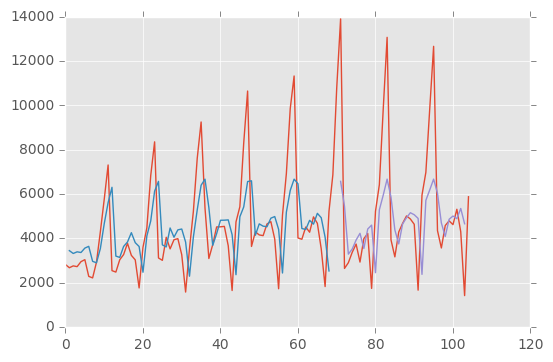

In [497]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(data)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(data))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

### Key points
#### ARIMA model gave us a RMSE of 350
#### SARIMA model gave us a RMSE of 328
#### LSTM's performed very poorly on the data and gave us a RMSE of 2660
#### The reason why LSTM's  might have failed is due to insufficient Data point, we just had 105 instances in our Dataset.
#### The performance of the LSTM's generally gets better as we feed it more Data.